In [1]:
import util
%matplotlib inline
%precision 4
import pystan
import numpy as np
import pandas as pd



In [46]:
year = 2016
tag = 'top-200'
limit = 200

In [47]:

sqlTxt = '''
select * from (select year, player_id, row_number from rank_view where year = %s  limit %s) r 
    join scores_view s 
    using (player_id, year) order by r.row_number, player_id, year, permanent_tournament_id, round;
'''
scores = util.pd_from_sql(sqlTxt, [year, limit])
num_scores = len (scores)
player_ids = scores['player_id'].unique()
num_players = len (player_ids)
player_map = dict(zip(player_ids, range(1,num_players + 1)))
player_map_reverse = dict(zip(range(1,num_players + 1), player_ids ))
tournament_ids = scores['permanent_tournament_id'].unique()
num_tournaments = len (tournament_ids)
tournament_map = dict(zip(tournament_ids, range(1, num_tournaments + 1)))
tournament_map_reverse = dict(zip(range(1, num_tournaments + 1), tournament_ids))
dat = sorted([[player_map[i[0]], tournament_map[i[4]], i[6]] for i in scores.as_matrix()], key = lambda (el): el[0])
p, t, y = zip(*dat)
rounds = np.zeros([limit])
for s in p:
    rounds[s-1] += 1
rounds = rounds.tolist()

In [48]:
code = """
data {
  int N;
  int N_P;
  int N_T;
  int y[N];
  int p[N];
  int t[N];
}
# Trending Model
parameters {
  real alpha[N_T];
  real<lower=0, upper=7> sigma[N_P];
  real<lower=65, upper=75> tau[N_P];
} 
model {
  alpha ~ normal(0, 2);
  for (n in 1:N) {
    y[n] ~ normal(alpha[t[n]] + tau[p[n]], sigma[p[n]]);
    
  } 
}

"""
data = {
    'N': num_scores,
    'y': y,
    'p' : p,
    't' : t,
    'N_P' : num_players,
    'N_T' : num_tournaments
}

fit = pystan.stan(model_code=code, data=data, iter=4000, chains=4)
params = fit.summary()['summary']
print fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d1e34255992ca7a42dc9c2d7e0b3e5e NOW.


Inference for Stan model: anon_model_8d1e34255992ca7a42dc9c2d7e0b3e5e.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]    -2.64    0.05   0.33  -3.28  -2.86  -2.65  -2.42  -1.98   44.0   1.09
alpha[1]    -0.15    0.05   0.33  -0.78  -0.37  -0.16   0.07   0.52   44.0   1.09
alpha[2]     0.78    0.05   0.33   0.15   0.55   0.78    1.0   1.45   44.0   1.09
alpha[3]     1.39    0.05   0.33   0.74   1.16   1.39   1.61   2.04   45.0   1.09
alpha[4]      1.9    0.05   0.33   1.26   1.67   1.89   2.12   2.55   44.0   1.09
alpha[5]    -0.83    0.05   0.33  -1.46  -1.05  -0.83  -0.61  -0.16   45.0   1.09
alpha[6]     1.04    0.05   0.33    0.4   0.81   1.03   1.26   1.71   43.0   1.09
alpha[7]     0.76    0.05   0.35   0.09   0.52   0.75   0.99   1.43   47.0   1.08
alpha[8]    -0.43    0.05   0.34  -1.08  -0.65  -0.43  -0.21   0.25   46.

In [49]:
t_range = range(0,num_tournaments)
d = {
    'permanent_tournament_id': pd.Series([tournament_map_reverse[i+1] for i in t_range]),
    'tag': pd.Series([tag for i in t_range]),
    'year' : pd.Series([year for i in t_range]),
    'alpha': pd.Series([(round(params[i][0],3), round(params[i][1],3), round(params[i][2],3)) for i in t_range]),
}
t_stats = pd.DataFrame(d)
t_stats.to_sql(name= 'stan_tournaments', con= util.golf_engine, if_exists= 'append', index=False)


In [50]:
p_range = range(0,num_players)

def create_stat(parms, i, offset):
    j = offset+i
    return (parms[j][0], parms[j][1], parms[j][2] )

d = {
    'player_id': pd.Series([player_map_reverse[i+1] for i in p_range]),
    'tag': pd.Series([tag for i in p_range]),
    'year' : pd.Series([year for i in p_range]),  
    'sigma': pd.Series([create_stat(params, i, num_tournaments ) for i in p_range]),
    'tau': pd.Series([create_stat(params, i, num_tournaments+num_players ) for i in p_range])
}
p_stats = pd.DataFrame(d)
p_stats.to_sql(name= 'stan_players', con= util.golf_engine, if_exists= 'append', index=False)

0.0344736842105
3.1308 3.40579234632


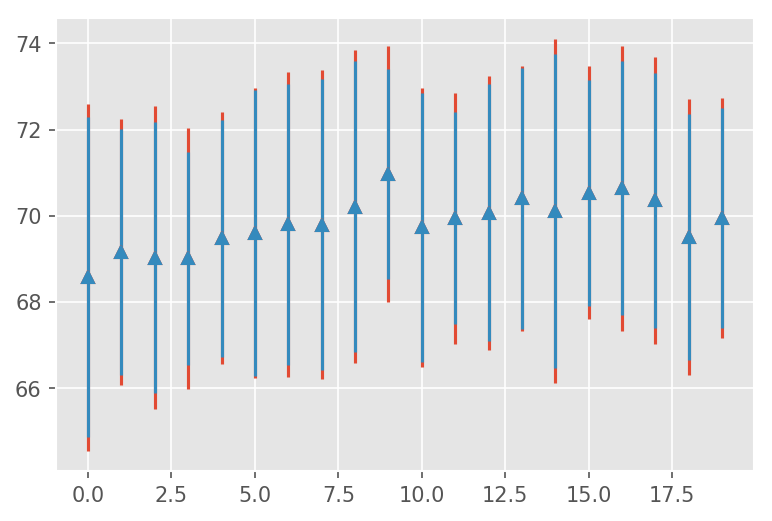

In [21]:
# offset = np.mean([round(means[i][0],2) for i in range(0,num_tournaments)])
# print offset
# top_players = 20
# avg_score = [round(means[i][0],2) for i in range(num_tournaments+num_players,num_tournaments+2*num_players)]
# std_score = [round(means[i][0],2) for i in range(num_tournaments,num_tournaments+num_players)]
# sqlTxt = '''
# select * from stats_view where year = 2014 limit 100; 
# '''
df = util.pd_from_sql(sqlTxt)
# foo = plt.errorbar(range(0, top_players), df['avg_score'][0:top_players], df['std_score'][0:top_players], linestyle='None', marker='^')
foo = plt.errorbar(range(0, top_players), avg_score[0:top_players] + offset, df['std_score'][0:top_players], linestyle='None', marker='^')
foo = plt.errorbar(range(0, top_players), avg_score[0:top_players] + offset, std_score[0:top_players], linestyle='None', marker='^')
print np.mean(std_score), np.mean(df['std_score']) 
